# Load libraries

In [17]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# image processing
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import img_to_array

# pretrained nets
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop

In [19]:
train_image_files_path = "/keras2production/fruits/Training/"
valid_image_files_path = "/keras2production/fruits/Test/"

# Keras

https://keras.io/

In [20]:
fruit_list = ["Apricot", "Avocado", "Banana", "Clementine", "Cocos", "Kiwi", "Lemon", "Limes", 
              "Mandarine", "Orange", "Peach", "Pineapple", "Plum", "Pomegranate", "Raspberry", "Strawberry"]
output_n = len(fruit_list)
size = 20
img_width = 20
img_height = 20
channels = 3
batch_size = 32

## Pretrained nets

https://keras.io/applications/

### Modify VGG16

- transfer learning (freeze all but the penultimate layer and re-train the last Dense layer) and 
- fine tuning (un-freeze the lower convolutional layers and retrain more layers)

Validation set: fit_generator has no option validation_split

https://keras.io/applications/#usage-examples-for-image-classification-models

In [21]:
# important: exclude top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

In [22]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

In [23]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-1]:
    layer.trainable = False

In [24]:
train_data_gen = ImageDataGenerator(
    rescale = 1 / 255
)

valid_data_gen = ImageDataGenerator(
    rescale = 1 / 255
)

train_image_array_gen = train_data_gen.flow_from_directory(
    train_image_files_path,
    target_size = (75,75),
    class_mode = 'categorical',
    classes = fruit_list,
    color_mode = 'rgb', 
    batch_size = batch_size,
    seed = 42)

valid_image_array_gen = valid_data_gen.flow_from_directory(
    valid_image_files_path,
    target_size = (75,75),
    class_mode = 'categorical',
    classes = fruit_list,
    color_mode = 'rgb', 
    batch_size = batch_size,
    seed = 42)

Found 7709 images belonging to 16 classes.
Found 2428 images belonging to 16 classes.


Shape:(75, 75, 3)
Number of classes:16
Classes:{'Apricot': 0, 'Avocado': 1, 'Banana': 2, 'Clementine': 3, 'Cocos': 4, 'Kiwi': 5, 'Lemon': 6, 'Limes': 7, 'Mandarine': 8, 'Orange': 9, 'Peach': 10, 'Pineapple': 11, 'Plum': 12, 'Pomegranate': 13, 'Raspberry': 14, 'Strawberry': 15}


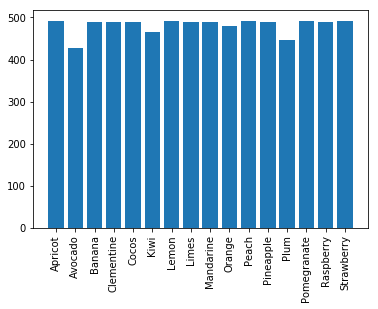

In [28]:
input_shape = train_image_array_gen.image_shape
classes = train_image_array_gen.class_indices
num_classes = len(classes)
class_counts = np.unique(train_image_array_gen.classes, return_counts=True)[1]
print("Shape:" + str(input_shape))
print("Number of classes:" + str(num_classes))
print("Classes:" + str(classes))

chart = plt.bar(classes.keys(), class_counts)
plt.xticks(rotation=90)
plt.show(chart)

In [29]:
train_samples = train_image_array_gen.n
valid_samples = valid_image_array_gen.n
print(train_samples, valid_samples)

7709 2428


In [30]:
# Create the model
model = Sequential()
 
# Add the base model
model.add(base_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(519, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_n, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 519)               1063431   
_________________________________________________________________
dropout_1 (Dropout)          (None, 519)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                8320      
Total params: 15,786,439
Trainable params: 1,071,751
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = RMSprop(lr = 0.0001, decay = 1e-6),
              metrics = ['accuracy'])

In [ ]:
history = model.fit_generator(
    train_image_array_gen,
    steps_per_epoch = int(train_samples / batch_size), 
    epochs = 3, 
    validation_data = valid_image_array_gen,
    validation_steps = int(valid_samples / batch_size),
    verbose = 1
)

Epoch 1/3
240/240 [==============================] - 231s 963ms/step - loss: 1.3507 - acc: 0.6624 - val_loss: 0.6682 - val_acc: 0.8883
Epoch 2/3
240/240 [==============================] - 230s 958ms/step - loss: 0.3939 - acc: 0.9416 - val_loss: 0.3183 - val_acc: 0.9153
Epoch 3/3
 42/240 [====>.........................] - ETA: 2:24 - loss: 0.2061 - acc: 0.9828

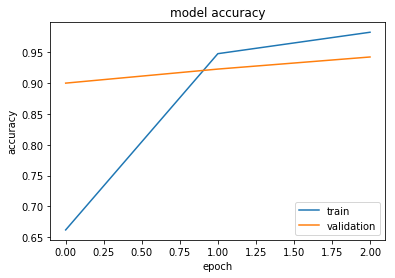

In [30]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'lower right')
plt.show()